# Machine Learning on gut microbiota of patients with Colorectal cancer (9): Predictive Model using Random Forest

Random Forest, a ensemble machine learning algorithm with multiple decision trees could be used for classification or regression algorithm, and it has an elegant way of dealing with nonlinear or linear data.
> Random forest aims to reduce the previously mentioned correlation issue by choosing only a subsample of the feature space at each split. Essentially, it aims to make the trees de-correlated and prune the trees by setting a stopping criteria for node splits, which I will cover in more detail later.


## Important Parameters

+ **number of estimators**: the number of trees for constructing forest.
+ **max depth of each tree**: the number of features per decision tree.
+ **max features per split**: it affects the performance of the whole dicision tree.

**estimator** also termed tree and depth control the complexity of the model, with larger *estimators* would result in better and high density forest and maximum depth helps fighting with overfitting.

`Random Forest doesn't require careful preprocessing such as normalization of data`. Standardization is an important requirement for many classification models that should be handled when implementing pre-processing. Some models (like neural networks) can perform poorly if pre-processing isn't considered, so the `describe()` function is a good indicator for standardization. Fortunately, random forest does not require any pre-processing.

## Loading libraries

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import time
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split

import seaborn as sns
#plt.style.use('fivethirtyeight')
plt.style.use('fivethirtyeight')
sns.set_style("darkgrid")

plt.rcParams['figure.figsize'] = (8, 4)

## Importing data

In [23]:
'''
# CLR-transformed data
data_df = pd.read_table('./dataset/MergeData_clr.tsv', sep="\t", index_col=0)
data = data_df.reset_index(drop=True)
data.head()

# significant species
data_df = pd.read_table('./dataset/MergeData_clr_signif.tsv', sep="\t", index_col=0)
data = data_df.reset_index(drop=True)
data.head()
'''

# raw data
data_df = pd.read_table('./dataset/MergeData.tsv', sep="\t", index_col=0)
data = data_df.reset_index(drop=True)
data.head()

,disease,s__Bacteroides_plebeius,s__Bacteroides_dorei,s__Faecalibacterium_prausnitzii,s__Eubacterium_eligens,s__Bacteroides_ovatus,s__Parabacteroides_distasonis,s__Ruminococcus_gnavus,s__Phascolarctobacterium_faecium,s__Bacteroides_uniformis,...,s__Bacteroides_finegoldii,s__Haemophilus_sp_HMSC71H05,s__Clostridium_saccharolyticum,s__Streptococcus_anginosus_group,s__Streptococcus_sp_A12,s__Klebsiella_pneumoniae,s__Bacteroides_coprocola,s__Ruminococcus_lactaris,s__Turicimonas_muris,s__Proteobacteria_bacterium_CAG_139
0,healthy,46509517,8249892,3696318,3265545,2871853,2327330,1920299,1506928,1371476,...,0,0,0,0,0,0,0,0,0,0
1,healthy,5334509,230275,2053756,182914,289955,89183,35688,0,729206,...,0,0,0,0,0,0,0,0,0,0
2,healthy,6868169,4054008,3267707,0,1097263,990122,1490407,0,1272701,...,0,0,0,0,0,0,0,0,0,0
3,healthy,1029678,2029259,661965,114447,110111,2705778,59274,0,940124,...,0,0,0,0,0,0,0,0,0,0
4,CRC,7520,2318235,350665,546829,564558,2529966,4608830,0,1888066,...,512018,137432,71548,15826,0,0,0,0,0,0


## Missing values or Occurrence

the occurrence per features

In [24]:
data.iloc[:, 1:].apply(lambda x: np.count_nonzero(x)/len(x), axis=0)

s__Bacteroides_plebeius                0.436508
s__Bacteroides_dorei                   0.658730
s__Faecalibacterium_prausnitzii        0.902778
s__Eubacterium_eligens                 0.533730
s__Bacteroides_ovatus                  0.793651
                                         ...   
s__Klebsiella_pneumoniae               0.251984
s__Bacteroides_coprocola               0.257937
s__Ruminococcus_lactaris               0.218254
s__Turicimonas_muris                   0.206349
s__Proteobacteria_bacterium_CAG_139    0.263889
Length: 151, dtype: float64

In [25]:
print("Here's the dimensions of our data frame:\n", data.shape)
print("Here's the data types of our columns:\n", data.dtypes)

Here's the dimensions of our data frame:
 (504, 152)
Here's the data types of our columns:
 disease                                object
s__Bacteroides_plebeius                 int64
s__Bacteroides_dorei                    int64
s__Faecalibacterium_prausnitzii         int64
s__Eubacterium_eligens                  int64
                                        ...  
s__Klebsiella_pneumoniae                int64
s__Bacteroides_coprocola                int64
s__Ruminococcus_lactaris                int64
s__Turicimonas_muris                    int64
s__Proteobacteria_bacterium_CAG_139     int64
Length: 152, dtype: object


In [74]:
data.describe()

,s__Bacteroides_plebeius,s__Bacteroides_dorei,s__Faecalibacterium_prausnitzii,s__Eubacterium_eligens,s__Bacteroides_ovatus,s__Parabacteroides_distasonis,s__Ruminococcus_gnavus,s__Phascolarctobacterium_faecium,s__Bacteroides_uniformis,s__Bifidobacterium_longum,...,s__Bacteroides_finegoldii,s__Haemophilus_sp_HMSC71H05,s__Clostridium_saccharolyticum,s__Streptococcus_anginosus_group,s__Streptococcus_sp_A12,s__Klebsiella_pneumoniae,s__Bacteroides_coprocola,s__Ruminococcus_lactaris,s__Turicimonas_muris,s__Proteobacteria_bacterium_CAG_139
count,5.040000e+02,5.040000e+02,5.040000e+02,5.040000e+02,5.040000e+02,5.040000e+02,5.040000e+02,5.040000e+02,5.040000e+02,5.040000e+02,...,5.040000e+02,5.040000e+02,504.000000,504.000000,504.000000,5.040000e+02,5.040000e+02,5.040000e+02,504.000000,5.040000e+02
mean,2.139221e+06,1.853404e+06,1.639697e+06,7.471533e+05,5.702796e+05,1.189482e+06,8.616634e+05,8.704456e+04,2.655816e+06,4.948624e+05,...,1.896052e+05,1.434993e+04,16513.160714,9621.785714,1705.916667,2.354459e+05,4.195657e+05,1.364957e+05,3334.486111,4.703426e+04
std,4.689115e+06,3.560063e+06,1.698016e+06,1.656732e+06,1.403095e+06,2.045147e+06,2.860133e+06,2.014462e+05,3.023979e+06,1.583632e+06,...,6.347103e+05,1.339195e+05,63994.560492,37684.680559,9572.428444,1.500337e+06,1.146908e+06,4.313418e+05,18921.337212,2.234608e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,0.000000e+00,0.000000e+00,3.653348e+05,0.000000e+00,9.511500e+03,1.316185e+05,6.770250e+03,0.000000e+00,5.021035e+05,2.227000e+03,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
50%,0.000000e+00,1.541615e+05,1.108265e+06,1.269250e+04,1.376850e+05,5.198215e+05,1.254780e+05,0.000000e+00,1.617164e+06,9.181750e+04,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
75%,2.154796e+06,2.206212e+06,2.411498e+06,8.205942e+05,4.613352e+05,1.451609e+06,6.393728e+05,6.190750e+04,3.725370e+06,3.613370e+05,...,4.488500e+03,0.000000e+00,0.000000,1210.250000,0.000000,1.237500e+03,1.618850e+04,0.000000e+00,0.000000,5.255000e+02
max,4.650952e+07,2.704303e+07,1.033825e+07,2.099930e+07,2.080088e+07,2.867909e+07,4.852190e+07,1.819512e+06,1.865031e+07,2.360833e+07,...,5.143085e+06,2.870102e+06,546273.000000,494519.000000,152204.000000,2.599798e+07,7.396682e+06,5.114972e+06,290556.000000,2.872330e+06


## Class balance

Displaying the counts by values and plot

In [26]:
def print_rate(data_frame, col):
    try:
        col_vals = data_frame[col].value_counts()
        col_vals = col_vals.reset_index()
        if len(col_vals['index']) > 20:
            print('Warning: values in column are more than 20 \nPlease try a column with lower value counts!')
        else:
            f = lambda x, y: 100 * (x / sum(y))
            for i in range(0, len(col_vals['index'])):
                print('{0} accounts for {1:.2f}% of the {2} column'\
                      .format(col_vals['index'][i], f(col_vals[col].iloc[i], col_vals[col]), col))
    except KeyError as e:
        print('{0}: Not found'.format(e))
        print('Please choose the right column name!')

print_rate(data, 'disease')

CRC accounts for 51.19% of the disease column
healthy accounts for 48.81% of the disease column


[Text(0, 0, '246'), Text(0, 0, '258')]

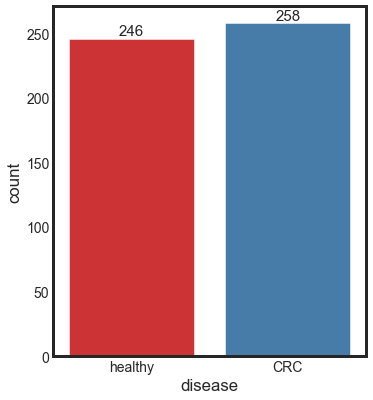

In [50]:
sns.set_style("white")
sns.set_context({"figure.figsize": (5, 6)})
ax = sns.countplot(x = 'disease', data = data, label = "Count", palette = "Set1")
ax.bar_label(ax.containers[0], fontsize=15)

## Distribution of features

Taking a look at the distribution of each feature and see how they are different between 'healthy' and 'CRC'. To see the distribution of multiple variables, using violin plot, swarm plot or box plot.

Here, we choose 10 features to visualization

+ standardizing data and gathering data into long data 

In [55]:
from sklearn.preprocessing import StandardScaler


df_features = data.iloc[:, 1:]

scaler = StandardScaler()
scaler.fit(df_features)

features_scaled = scaler.transform(df_features)
features_scaled = pd.DataFrame(data=features_scaled,
                               columns=df_features.columns)

data_scaled = pd.concat([features_scaled, data['disease']], axis=1)

data_scaled_melt = pd.melt(data_scaled, id_vars='disease', var_name='features', value_name='value')
data_scaled_melt.head(10)

,disease,features,value
0,healthy,s__Bacteroides_plebeius,9.471804
1,healthy,s__Bacteroides_plebeius,0.682104
2,healthy,s__Bacteroides_plebeius,1.009497
3,healthy,s__Bacteroides_plebeius,-0.236856
4,CRC,s__Bacteroides_plebeius,-0.455058
5,CRC,s__Bacteroides_plebeius,-0.456641
6,CRC,s__Bacteroides_plebeius,-0.455913
7,CRC,s__Bacteroides_plebeius,0.193993
8,CRC,s__Bacteroides_plebeius,-0.437240
9,CRC,s__Bacteroides_plebeius,-0.456663


+ violin plot

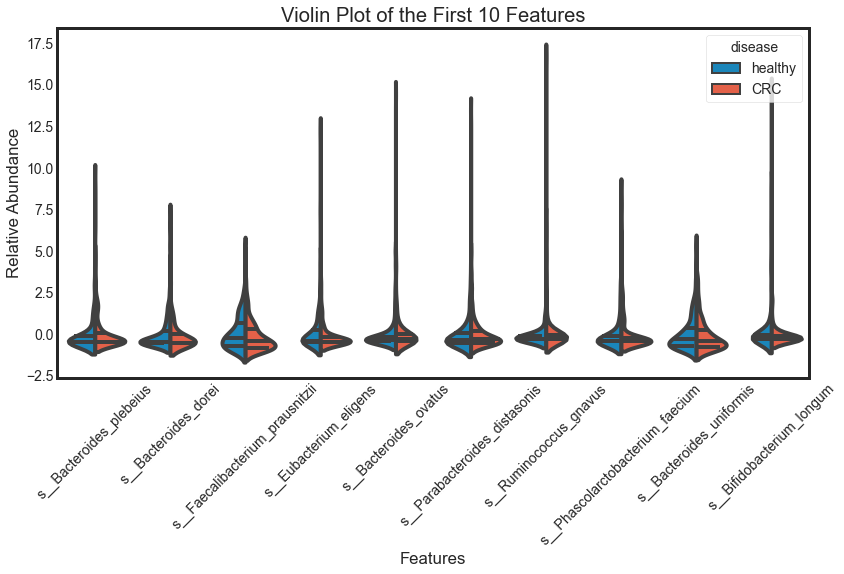

In [56]:
def violin_plot(features, name):
    """
    This function creates violin plots of features given in the argument.
    """
    # Create query
    query = ''
    for x in features:
        query += "features == '" + str(x) + "' or "
    query = query[0: -4]

    # Create data for visualization
    plotdata = data_scaled_melt.query(query)

    # Plot figure
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='features',
                   y='value',
                   hue='disease',
                   data=plotdata,
                   split=True,
                   inner="quart")
    plt.xticks(rotation=45)
    plt.title(name)
    plt.xlabel("Features")
    plt.ylabel("Relative Abundance")


violin_plot(data.columns[1:11], "Violin Plot of the First 10 Features")

+ swarm plot

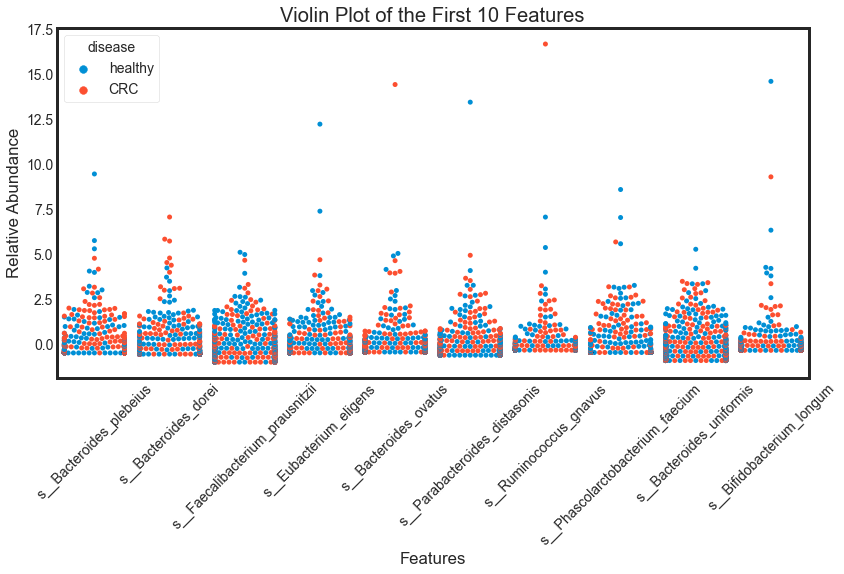

In [58]:
%%capture --no-display

def swarm_plot(features, name):
    """
    This function creates swarm plots of features given in the argument.
    """
    # Create query
    query = ''
    for x in features:
        query += "features == '" + str(x) + "' or "
    query = query[0:-4]

    # Create data for visualization
    data = data_scaled_melt.query(query)

    # Plot figure
    plt.figure(figsize=(12, 6))
    sns.swarmplot(x='features', 
                  y='value', 
                  hue='disease', 
                  data=data)
    plt.xticks(rotation=45)
    plt.title(name)
    plt.xlabel("Features")
    plt.ylabel("Relative Abundance")

swarm_plot(data.columns[1:11], "Swarm Plot of the First 10 Features")

+ boxplot

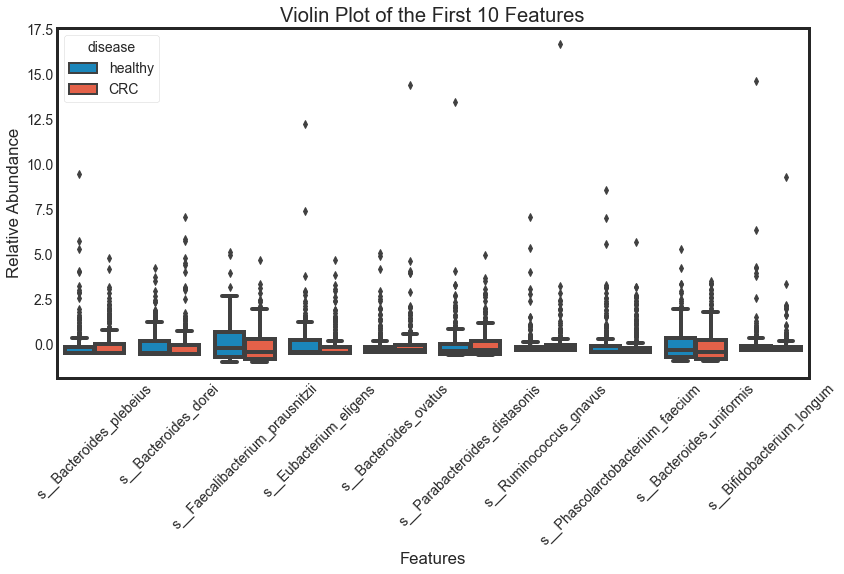

In [59]:
def box_plot(features, name):
    """
    This function creates box plots of features given in the argument.
    """
    # Create query
    query = ''
    for x in features:
        query += "features == '" + str(x) + "' or "
    query = query[0:-4]

    # Create data for visualization
    data = data_scaled_melt.query(query)

    # Plot figure
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='features', 
                y='value', 
                hue='disease', 
                data=data)
    plt.xticks(rotation=45)
    plt.title(name)
    plt.xlabel("Features")
    plt.ylabel("Relative Abundance")

box_plot(data.columns[1:11], "Box Plot of the First 10 Features")

The violin plot is very efficient in comparing distributions of different variables. The classification becomes clear in the swarm plot. Finally, the box plots are useful in comparing median and detecing outliers.

From above plots we can draw some insights from the data:

+ The median of some features are very different between 'healthy' and 'CRC'. This seperation can be seen clearly in the box plots. They can be very good features for classification. For examples: *s__Faecalibacterium_prausnitzii*.

+ However, there are distributions looking similar between 'healthy' and 'CRC'. For examples: *s__Bacteroides_plebeius*. These features are weak in classifying data.

+ Some features have similar distributions, thus might be highly correlated with each other. We should not include all these hightly correlated varibles in our predicting model.

## Correlation

As discussed above, some dependent variables in the dataset might be highly correlated with each other. Let's explore the correlation of three examples above.

In [62]:
def correlation(data_frame, var):
    """
    1. Print correlation
    2. Create jointplot
    """
    # Print correlation
    print("Correlation: ", data_frame[[var[0], var[1]]].corr().iloc[1, 0])

    # Create jointplot
    plt.figure(figsize=(6, 6))
    sns.jointplot(data_frame[(var[0])], data_frame[(var[1])], kind='reg')

<Figure size 432x432 with 0 Axes>

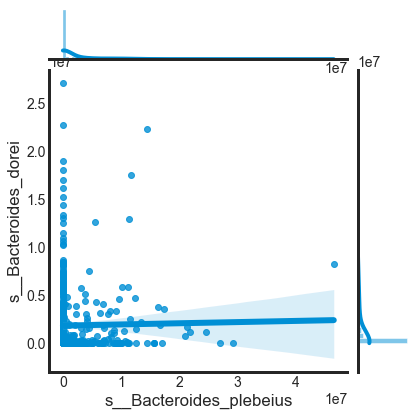

In [65]:
%%capture --no-display
correlation(data, ['s__Bacteroides_plebeius', 's__Bacteroides_dorei'])

<AxesSubplot:>

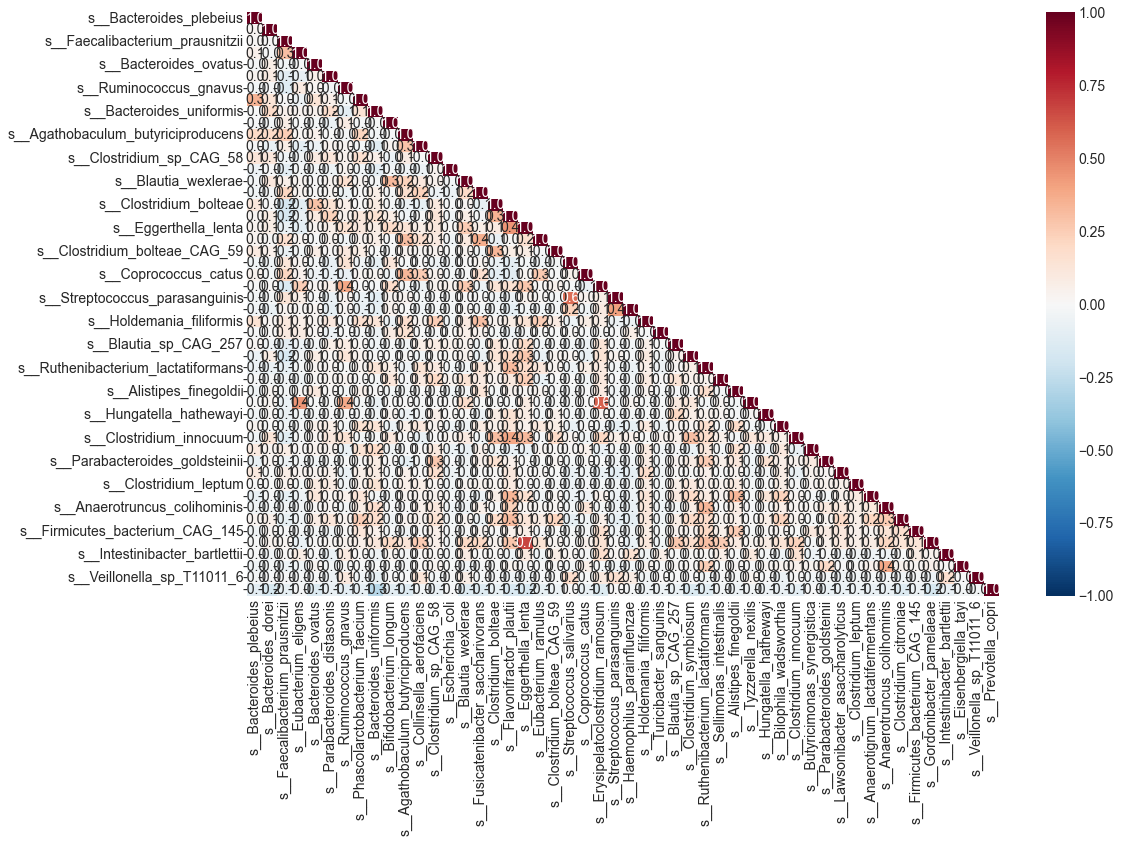

In [71]:
%%capture --no-display

# Create correlation matrix
corr_mat = data.iloc[:, 1:51].corr()

# Create mask
mask = np.zeros_like(corr_mat, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat, 
            annot=True, 
            fmt='.1f',
            cmap='RdBu_r', 
            vmin=-1, 
            vmax=1,
            mask=mask)

From the heat map, we can see that many variables in the dataset are highly correlated. What are variables having correlation greater than 0.6?

<AxesSubplot:>

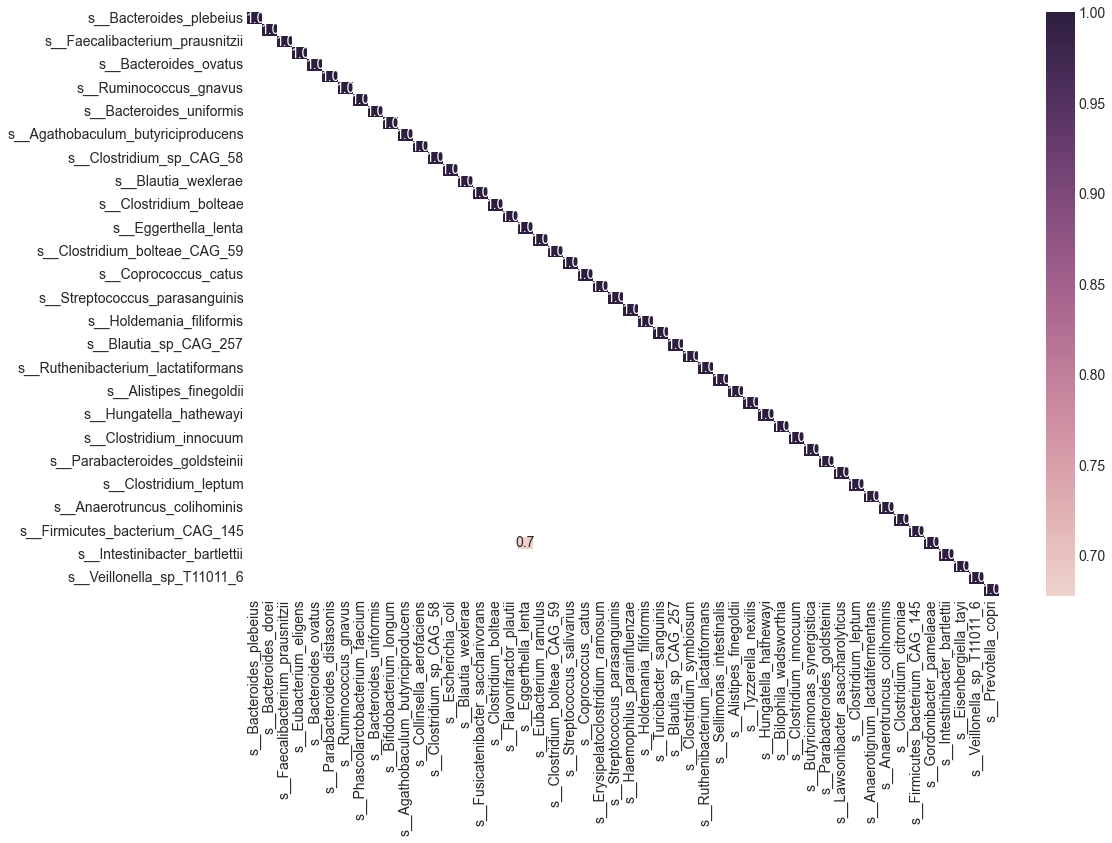

In [73]:
plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat[corr_mat > 0.6], 
            annot=True,
            fmt='.1f', 
            cmap=sns.cubehelix_palette(200), 
            mask=mask)

## Transforming the string label into numeric lable

The RandomForestClassifier in sklearn does not accept string labels for categorical variables.

+ 0 = Healthy = Healthy Control
+ 1 = CRC = Colorectal Cancer

In [75]:
data['disease'] = data['disease'].map({'healthy':0, 'CRC':1})
data.head(n=6)

,disease,s__Bacteroides_plebeius,s__Bacteroides_dorei,s__Faecalibacterium_prausnitzii,s__Eubacterium_eligens,s__Bacteroides_ovatus,s__Parabacteroides_distasonis,s__Ruminococcus_gnavus,s__Phascolarctobacterium_faecium,s__Bacteroides_uniformis,...,s__Bacteroides_finegoldii,s__Haemophilus_sp_HMSC71H05,s__Clostridium_saccharolyticum,s__Streptococcus_anginosus_group,s__Streptococcus_sp_A12,s__Klebsiella_pneumoniae,s__Bacteroides_coprocola,s__Ruminococcus_lactaris,s__Turicimonas_muris,s__Proteobacteria_bacterium_CAG_139
0,0,46509517,8249892,3696318,3265545,2871853,2327330,1920299,1506928,1371476,...,0,0,0,0,0,0,0,0,0,0
1,0,5334509,230275,2053756,182914,289955,89183,35688,0,729206,...,0,0,0,0,0,0,0,0,0,0
2,0,6868169,4054008,3267707,0,1097263,990122,1490407,0,1272701,...,0,0,0,0,0,0,0,0,0,0
3,0,1029678,2029259,661965,114447,110111,2705778,59274,0,940124,...,0,0,0,0,0,0,0,0,0,0
4,1,7520,2318235,350665,546829,564558,2529966,4608830,0,1888066,...,512018,137432,71548,15826,0,0,0,0,0,0
5,1,105,0,393585,0,580,505263,781136,261268,6177,...,0,0,4369,0,158,0,0,0,0,0


## Creating Training and Test Sets

In [77]:
X = data.iloc[:, 1:]
Y = data['disease']

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size = 0.30, random_state = 42)
# Cleaning test sets to avoid future warning messages
y_train = y_train.values.ravel() 
y_test = y_test.values.ravel()  

## Summary

Worked through a classification predictive modeling machine learning problem from end-to-end using Python. Specifically, the steps covered were:
1. Problem Definition (Breast Cancer data).
2. Loading the Dataset.
3. Analyze Data (same scale but different distributions of data).
    * Evaluate Algorithms (KNN looked good).
    * Evaluate Algorithms with Standardization (KNN and SVM looked good).
4. Algorithm Tuning (K=19 for KNN was good, SVM with an RBF kernel and C=100 was best).. 
5. Finalize Model (use all training data and confirm using validation dataset)

## Reference

* [Breast-cancer-risk-prediction](https://github.com/Jean-njoroge/Breast-cancer-risk-prediction)